In [2]:
##Load all the required libraries...

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import time
import pandas as pd

from tools.base import *
from tools.ddmtd import ddmtd
from time import sleep

In [3]:
import matplotlib
matplotlib.style.available
# import scienceplots
# matplotlib.style.use(['seaborn-v0_8-darkgrid', 'science'])
# plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 300

In [4]:
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [10]:
# Setting all the variables...
N=100000  #Setting the DDMTD N
freq="160"#in MHz #Setting the input clock frequency
pll_config_folder="../rpi_side/PLL_Conf/"
fig_save_folder = f"./dcps3Test/figures/N{N}/"
data_save_folder = f"./dcps3Test/data/N{N}/"
!mkdir -p {fig_save_folder} #create those directories
!mkdir -p {data_save_folder} #create those directories
run_number = 1
coarse_control = 0
fine_control = 0
stage4_tune = 2
stage5_tune = 3
channel = 3
run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}"

In [11]:
dat = []
for coarse_control in range(0,32,1):
# for coarse_control in [0,1,2,4,8,16]:
    # run_name = f"f_{fine_control}"
    run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}"
    df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
    df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
    df = pd.concat((df1,df2),axis=1)
    # df

    # df.ddmtd2.diff().iloc[:].plot()
    # df.ddmtd1.diff().iloc[:].plot()


    # Create a DDMTD Object for analysis of the data
    data = ddmtd(df.iloc[:,:],channel=(1,2)) #creates a ddmtd object
    #Setting the correct N can recalculating all the scalings
    data.N = N  
    # data.N = 1000000 
    data.INPUT_FREQ = 160*10**6 #In Hz 
    data.Recalc()
    mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # print(
    # # np.mean(data.TIE_fall)*data.MULT_FACT*1000,
    # # np.mean(data.TIE_rise)*data.MULT_FACT*1000,
    # np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # )

    dat.append((coarse_control,mean_val))



Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.5999888212616236 kHz
BEAT Freq DDMTD2 = 1.5994301781888378 kHz
Recovered N of DDMTD1 = 99999.6986790432
Recovered N of DDMTD2 = 100034.62620492681
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6000057314946348 kHz
BEAT Freq DDMTD2 = 1.5994372544609283 kHz
Recovered N of DDMTD1 = 99998.64179645057
Recovered N of DDMTD2 = 100034.18362911989
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6002440586425217 kHz
BEAT Freq DDMTD2 = 1.5996739772062114 kHz
Recovered N of DDMTD1

Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6005788161336867 kHz
BEAT Freq DDMTD2 = 1.5997773912704973 kHz
Recovered N of DDMTD1 = 99962.8374455733
Recovered N of DDMTD2 = 100012.91485244315
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.5999906506769614 kHz
BEAT Freq DDMTD2 = 1.600735959222757 kHz
Recovered N of DDMTD1 = 99999.58434026099
Recovered N of DDMTD2 = 99953.0241662639
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6006280839915505 kHz
BEAT Freq DDMTD2 = 1.5998310949980497 kHz
Recovered N of DDMTD1 = 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Coarse Delay Channel 3: 2 3')

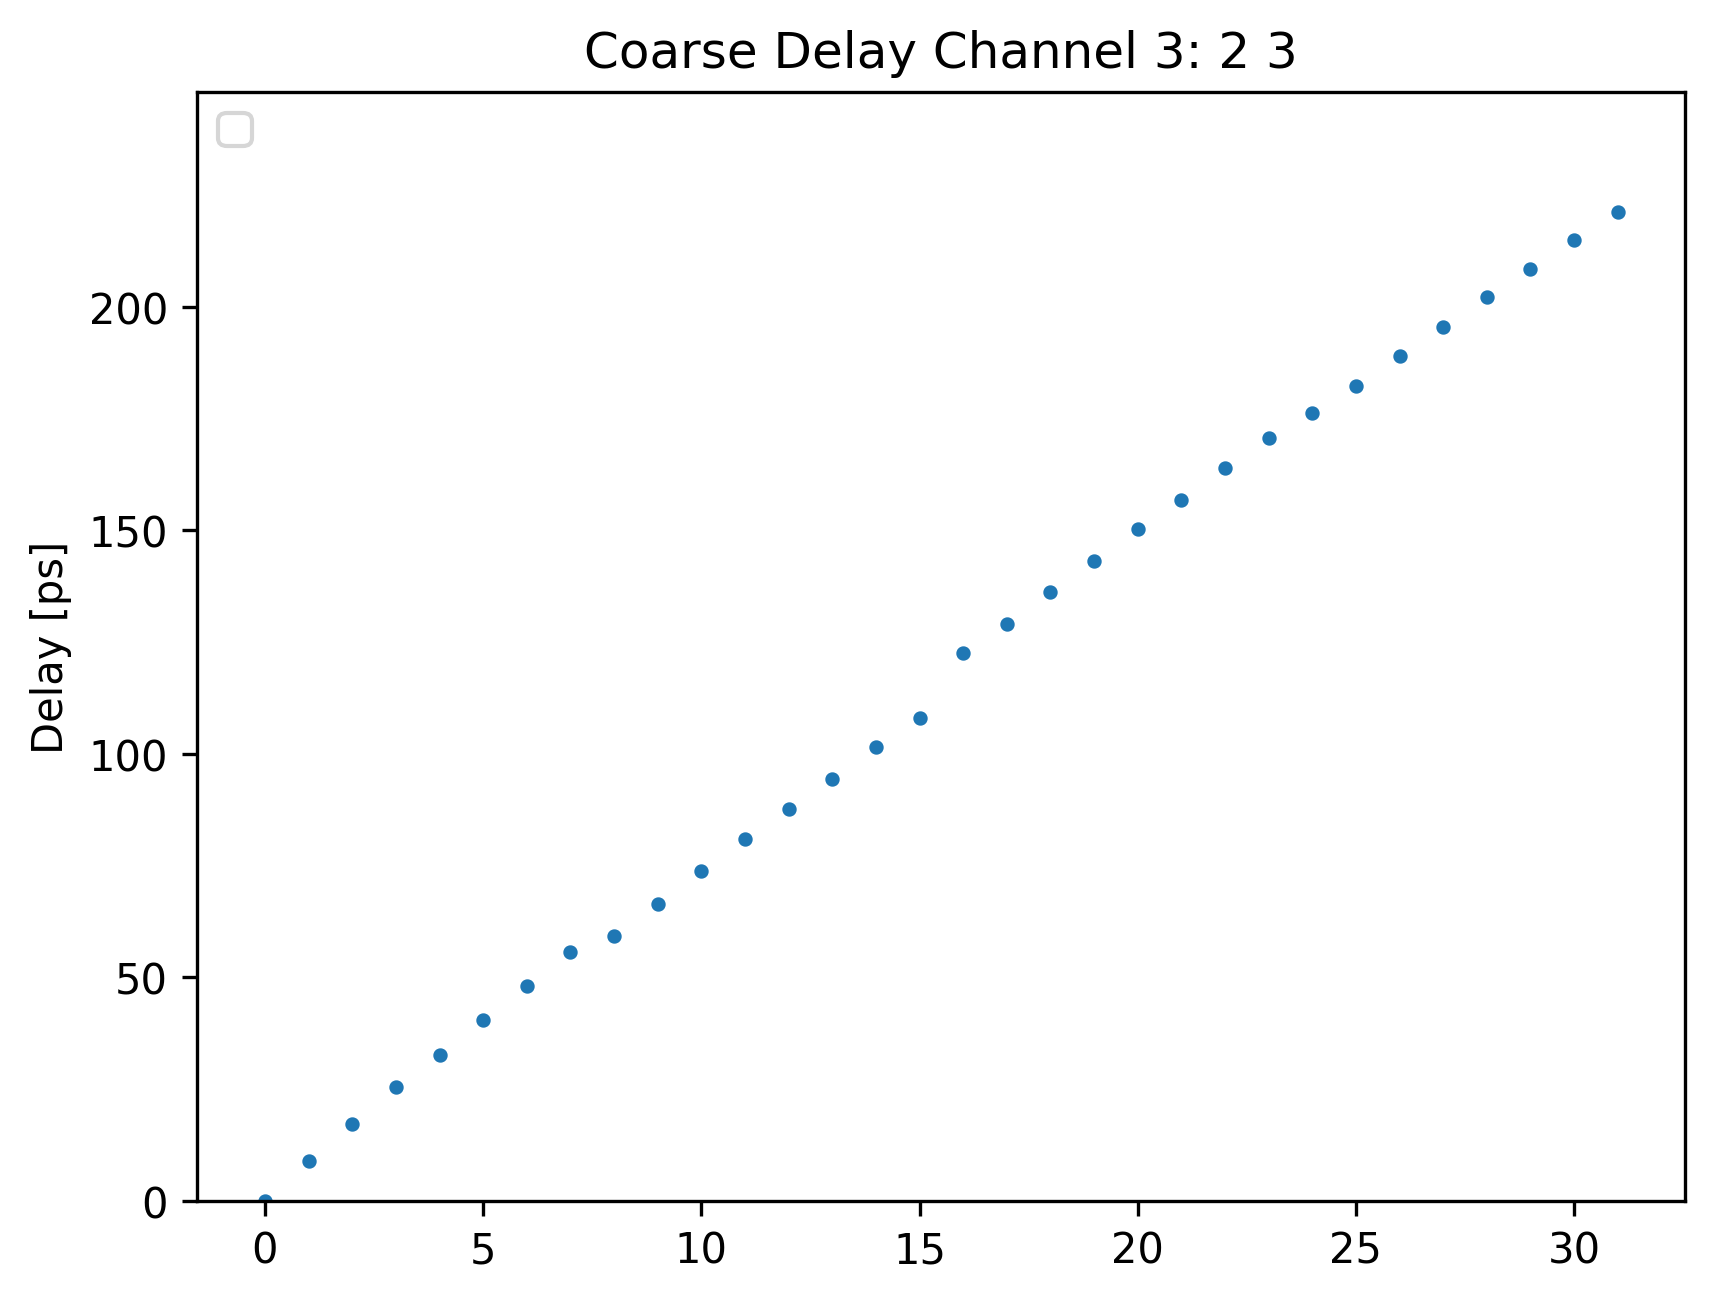

In [12]:
dat = np.asarray(dat)
x = dat.T[0]
y = -1*(dat.T[1]+200)%3125

y = y-y[0]

# x = x[:(len(x) - 1)]
# y = y[:(len(y) - 1)]

f,ax = plt.subplots()
# fit
popt,pcov = np.polyfit(x,y,1,cov=True)
p_e = np.sqrt(np.diag(pcov))
# ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

plt.scatter(x,y,s=6)

ax.set_ylim([0, 248])
ax.set_ylabel("Delay [ps]")
# ax.set_xlabel("Coarse Step")
ax.legend(loc="upper left",fontsize=10)
ax.set_title(f"Coarse Delay Channel {channel}: {stage4_tune} {stage5_tune}")

# FINE DELAY

In [24]:
dat = []
coarse_control = 0
fine_control = 0
stage4_tune = 0
stage5_tune = 0
channel = 2
run_no = 3
for fine_control in range(0,66,1): 
# for fine_control in range(50,66,2):
# for coarse_control in [0,2,4,8,16]:
    # run_name = f"f_{fine_control}"
    run_name = f"chan{channel}_f{fine_control}_c{coarse_control}_s4{stage4_tune}_s5{stage5_tune}"
    df1 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd1.txt",names=['edge1','ddmtd1'])
    df2 = pd.read_csv(f"{data_save_folder+run_name}_ddmtd2.txt",names=['edge2','ddmtd2'])
    df = pd.concat((df1,df2),axis=1)
    # df

    # df.ddmtd2.diff().iloc[:].plot()
    # df.ddmtd1.diff().iloc[:].plot()


    # Create a DDMTD Object for analysis of the data
    data = ddmtd(df.iloc[:,:],channel=(1,2)) #creates a ddmtd object
    #Setting the correct N can recalculating all the scalings
    data.N = N  
    # data.N = 1000000 
    data.INPUT_FREQ = 160*10**6 #In Hz 
    data.Recalc()
    mean_val = np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # print(
    # # np.mean(data.TIE_fall)*data.MULT_FACT*1000,
    # # np.mean(data.TIE_rise)*data.MULT_FACT*1000,
    # np.mean(np.concatenate((data.TIE_rise,data.TIE_fall)))*data.MULT_FACT*1000
    # )

    dat.append((fine_control,mean_val))

dat = np.asarray(dat[1:])





Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.5999888783838547 kHz
BEAT Freq DDMTD2 = 1.599429995525347 kHz
Recovered N of DDMTD1 = 99999.69510888969
Recovered N of DDMTD2 = 100034.63762941807
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6005150936647323 kHz
BEAT Freq DDMTD2 = 1.599955522892415 kHz
Recovered N of DDMTD1 = 99966.81733856582
Recovered N of DDMTD2 = 100001.77987870139
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.5999888238686133 kHz
BEAT Freq DDMTD2 = 1.59942233837489 kHz
Recovered N of DDMTD1 = 

Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6003748037684085 kHz
BEAT Freq DDMTD2 = 1.5998120992313871 kHz
Recovered N of DDMTD1 = 99975.580494801
Recovered N of DDMTD2 = 100010.74506991754
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.599988835196328 kHz
BEAT Freq DDMTD2 = 1.5994248853579973 kHz
Recovered N of DDMTD1 = 99999.69780812073
Recovered N of DDMTD2 = 100034.95724038807
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.599990418794064 kHz
BEAT Freq DDMTD2 = 1.5994190237639239 kHz
Recovered N of DDMTD1 = 

Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6002684559253666 kHz
BEAT Freq DDMTD2 = 1.599704655182227 kHz
Recovered N of DDMTD1 = 99982.22449712643
Recovered N of DDMTD2 = 100017.46228448275
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6003427619312178 kHz
BEAT Freq DDMTD2 = 1.5997765886062525 kHz
Recovered N of DDMTD1 = 99977.58219178082
Recovered N of DDMTD2 = 100012.96503244412
Recalculations Done.
N = 100000
Input Freq = 160.0 MHz
PLL Freq = 159.99840001599986 MHz
BEAT Freq = 1.5999840001599985 kHz
Err = 0.0625 ps
$$$$$$$$$$$$ Recovered Beat Freq $$$$$$$$$$$$
BEAT Freq DDMTD1 = 1.6005439063726952 kHz
BEAT Freq DDMTD2 = 1.599974701756297 kHz
Recovered N of DDMTD1 

Text(0.5, 1.0, 'Channel 2 FINE DELAY')

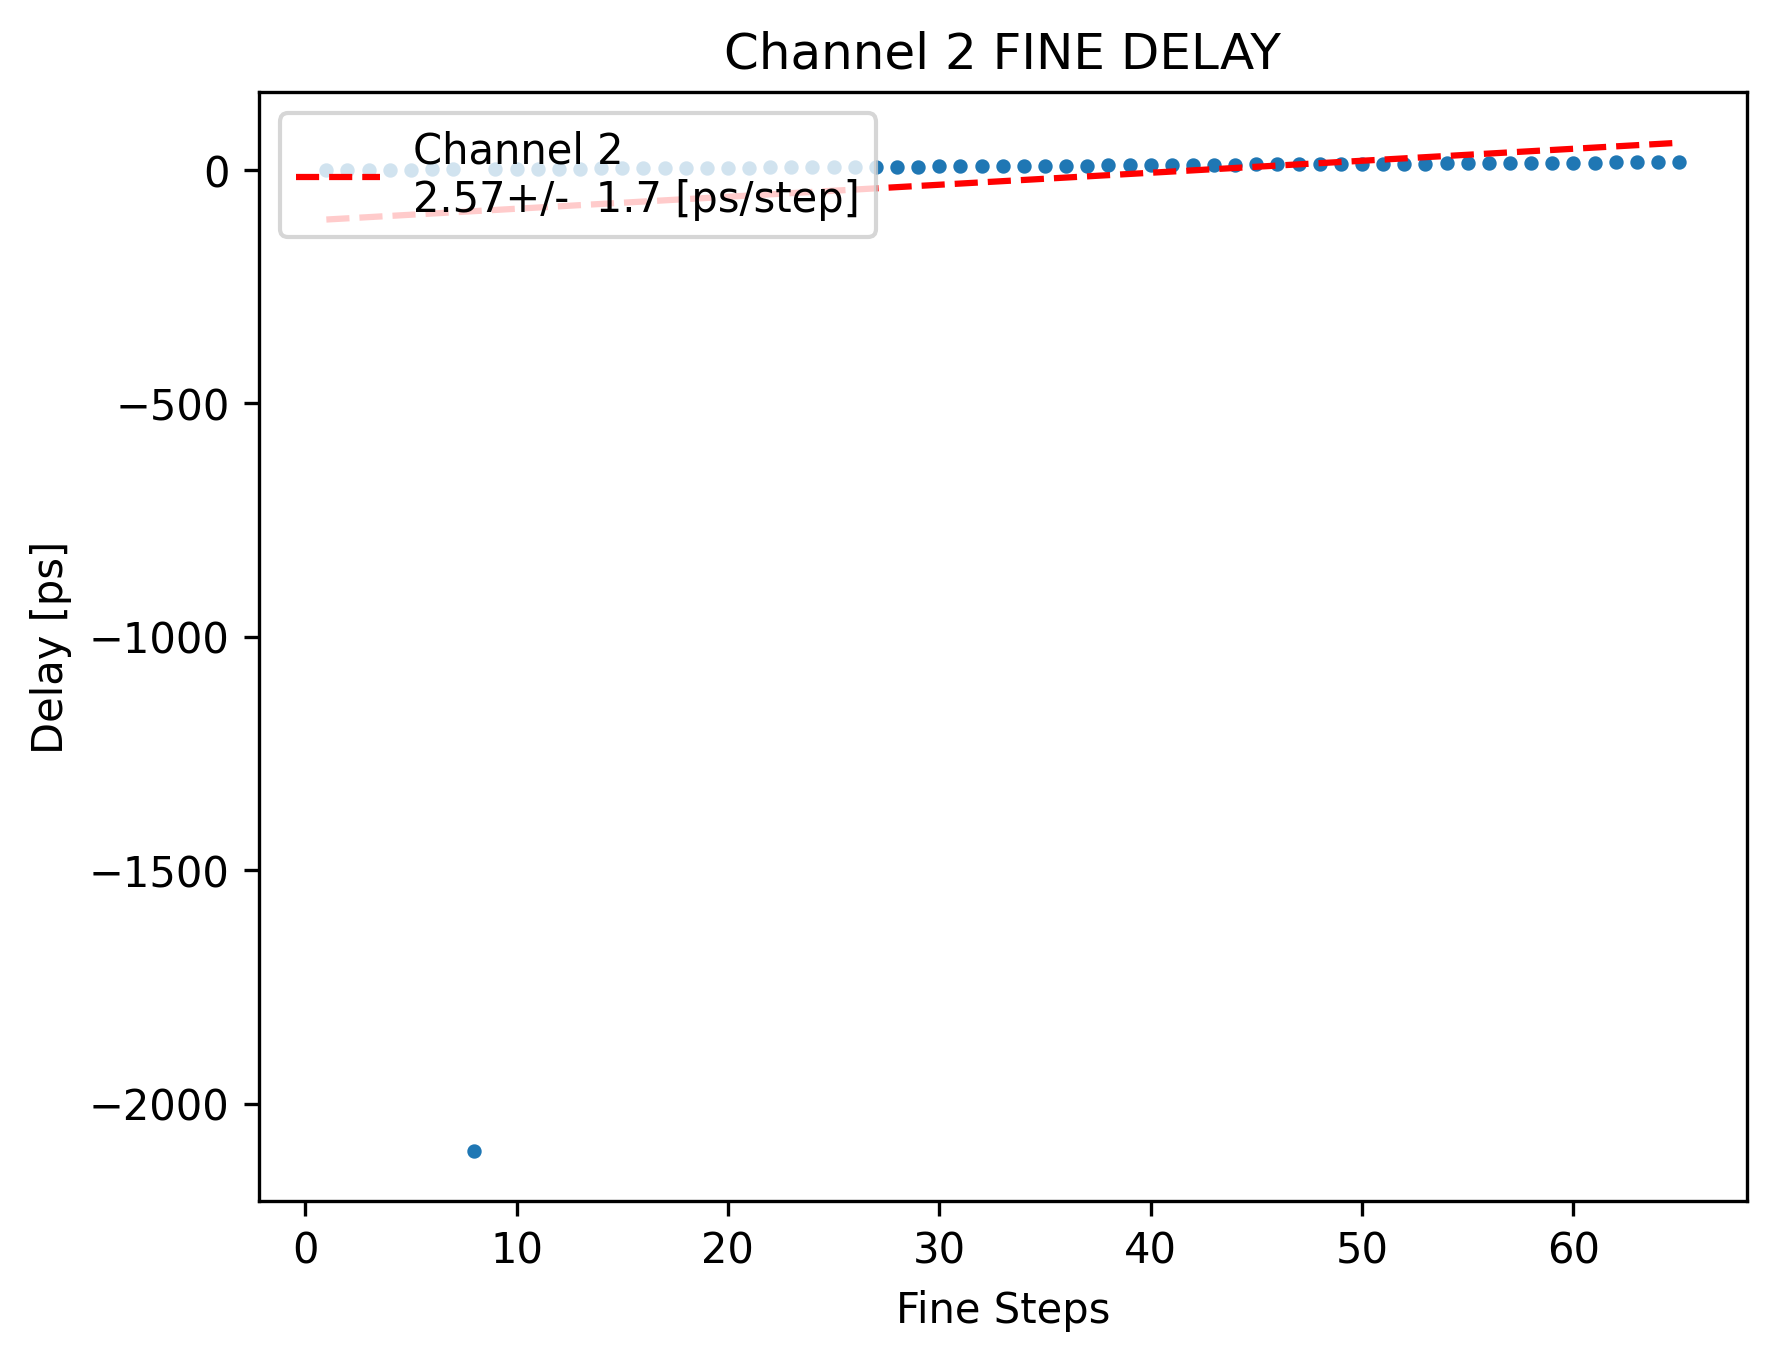

In [25]:
dat = np.asarray(dat)
x = dat.T[0]
y = -1*(dat.T[1]+200)%3125

y = y-y[0]

f,ax = plt.subplots()
# fit
popt,pcov = np.polyfit(x,y,1,cov=True)
p_e = np.sqrt(np.diag(pcov))
ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel {channel} \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")

plt.scatter(x,y,s=6)

ax.set_ylabel("Delay [ps]")
ax.set_xlabel("Fine Steps")
ax.legend(loc="upper left",fontsize=10)
ax.set_title(f"Channel {channel} FINE DELAY")